In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

from scipy import optimize

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 10, 5
font_size    = 16

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size
plt.rcParams[  "image.cmap"   ] =   default_cmap

plt.style.use(plt.style.available[10])

#set number of bins
nbins = 100

# 1. Import data

In [3]:
typo='Tlpk'
df = pd.HDFStore(f'corrections_6206_{typo}.h5')['/edf']

In [4]:
df.head()

,event,peak,loc,nslices,nhits,noqslices,noqhits,time,s1e,t0,...,x0,y0,z0,q0,e0,x,y,z,q,e
0,5210,0,0,104,1655,8,13435,1531471818538,801.035461,270.252944,...,-66.528209,79.494401,423.263062,27541.625000,583616.875000,-66.825338,79.747526,424.318138,34766.582861,651319.875416
1,21814,0,0,58,1359,4,14680,1531472144806,632.102478,458.911360,...,85.016451,-13.134833,214.083267,34229.054688,666197.437500,85.099823,-13.168215,214.265463,38542.483520,662014.040271
2,49749,0,0,9,25,3,44,1531472690381,726.294556,479.877016,...,-83.119565,32.872074,172.974396,275.492889,7469.683105,-83.119010,32.878988,172.973280,290.477525,7084.192211
3,49749,1,0,108,1589,5,15315,1531472690381,726.294556,479.877016,...,-26.369277,15.674682,280.453827,30718.068359,676024.750000,-26.538571,15.579407,280.736583,34243.763320,645719.975302
4,52392,0,0,93,1546,4,14350,1531472741667,595.690857,515.918773,...,85.341432,81.341013,184.272369,27199.216797,607946.750000,87.245057,82.637110,183.608361,33948.578788,654418.924694


In [5]:
df.tail()

,event,peak,loc,nslices,nhits,noqslices,noqhits,time,s1e,t0,...,x0,y0,z0,q0,e0,x,y,z,q,e
127,13570316,1,6,21,233,4,1271,1531738591182,683.893311,393.509707,...,-94.924503,-90.783249,347.348175,5916.046875,109398.054688,-94.951534,-90.631398,347.354700,6355.437176,111720.484823
128,13570316,2,6,9,18,4,86,1531738591182,683.893311,393.509707,...,-167.918788,-78.446538,372.137329,155.395599,5048.683105,-167.946559,-78.344220,372.143968,167.444701,6377.189686
129,13608879,0,6,128,1587,3,15703,1531739349981,690.532349,455.324627,...,-15.714926,-98.124315,249.191147,32004.345703,667838.125000,-14.658015,-99.219554,250.879422,34155.931921,653547.406691
130,13624811,0,6,65,1375,2,16090,1531739665570,594.783020,575.990404,...,16.938936,13.569984,105.947708,34915.554688,710540.687500,17.127476,13.616315,106.106061,36411.559878,653046.904272
131,13627180,0,6,56,1369,2,14793,1531739713650,553.944275,554.609548,...,7.476069,72.875485,124.352341,34274.781250,663201.875000,8.144051,74.757941,124.324568,37390.727615,642947.967889


# 2. ENERGY

## 2.1 Overview

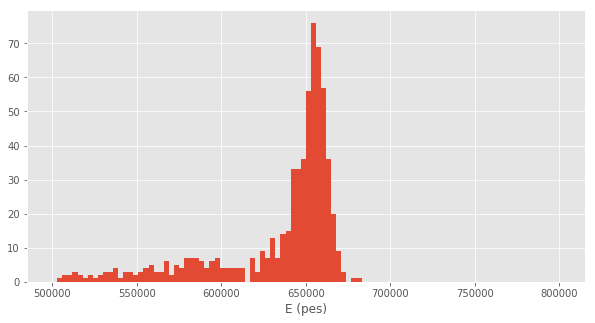

In [8]:
Emax = 800e3
Emin = 500e3

df['e'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E (pes)', fontsize=12);

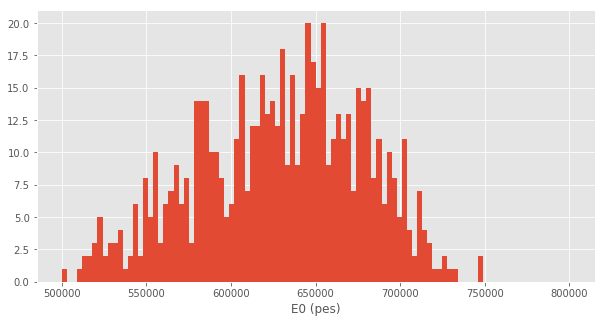

In [9]:
df['e0'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E0 (pes)', fontsize=12);

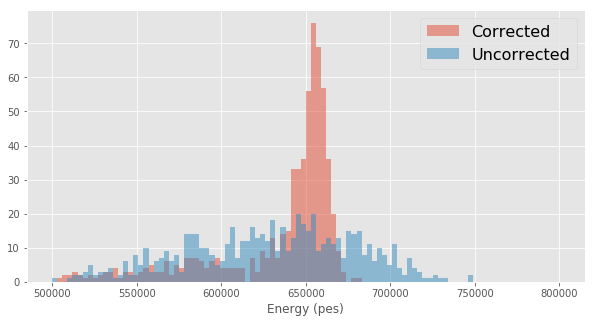

In [10]:
plt.hist(df['e'] , bins = nbins, range=(Emin, Emax), alpha=.5, label='Corrected' );
plt.hist(df['e0'], bins = nbins, range=(Emin, Emax), alpha=.5, label='Uncorrected' );
plt.legend(fontsize = 16);
plt.xlabel('Energy (pes)', fontsize=12);

## 2.2. Select region

In [30]:
Emax = 670e3
Emin = 640e3

In [31]:
edf = df[(df.e<Emax) & (df.e>Emin)]

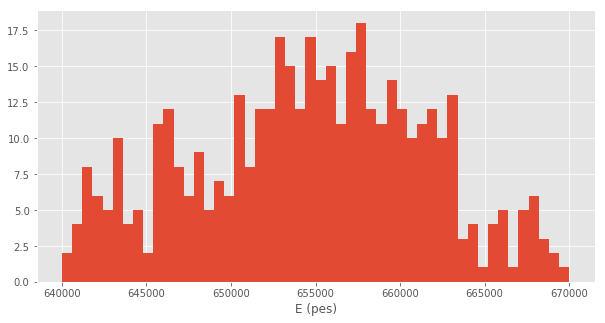

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

ydata, xdata, __ = ax.hist(edf['e'], bins=int(.5*nbins), range = (Emin,Emax));
plt.xlabel('E (pes)', fontsize=12);

## 2.3. Fitting photopeak

We perform a gaussian fit for the photopeak and assume a linear fit for background

$$F(E) = A e^{-(E-E_{ph})^2/2\sigma^2} + m(E-E_{min}) + c$$

In [33]:
def F(E, Eph, sig, A, m, c):
    return A * np.e**(-(E-Eph)**2/(2*sig**2)) + m*(E-Emin) + c

def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

In [34]:
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [np.mean(edf['e']), np.std(edf['e']), np.max(ydata), -1, np.mean(ydata)]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata),
                               bounds=([-np.inf, 0, -np.inf, -np.inf, -np.inf], np.inf))

Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

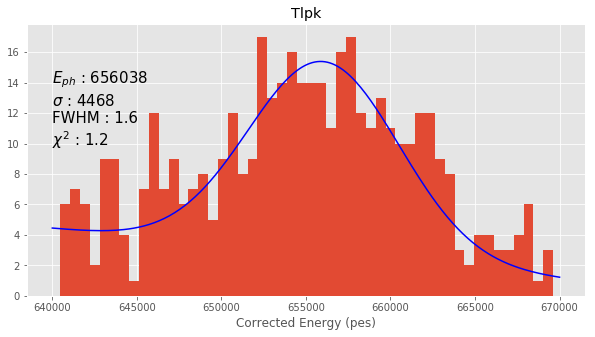

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(edf['e'], bins=int(.5*nbins));
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'b');

t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(640e3, 10, s = t, fontsize = 15);
ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{}'.format(typo));

In [38]:
print('Extrapolated FWHM:',sig/Eph * 235 * (2600/2458)**.5)

Extrapolated FWHM: 1.6461888449174698


## 2.4. Searching correlations

### 2.4.1. Corrected Energy correlations (E vs All variables)

In [39]:
var = edf.keys()
var = var[3:len(var)]
var

Index(['nslices', 'nhits', 'noqslices', 'noqhits', 'time', 's1e', 't0', 'rmax',
       'zmin', 'zmax', 'x0', 'y0', 'z0', 'q0', 'e0', 'x', 'y', 'z', 'q', 'e'],
      dtype='object')

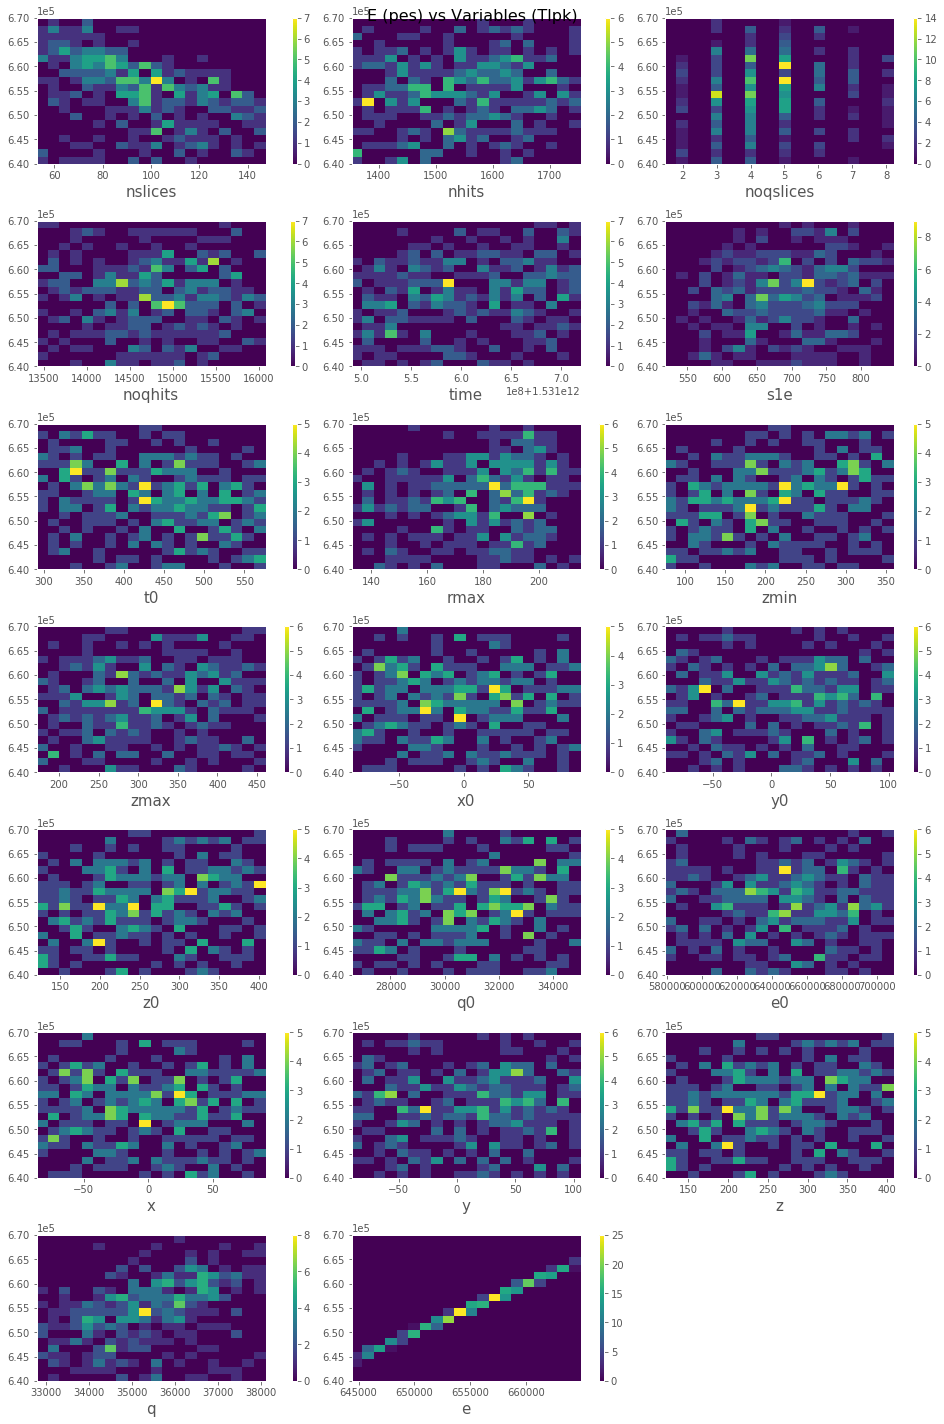

In [41]:
fig_e = plt.figure(figsize =[13, 20], constrained_layout=True);

gs_e = gridspec.GridSpec(round(len(var)/3+.5), 3, figure=fig_e);

i=0
for v in var:
    axes    = f'ax_e{v}   = fig_e.add_subplot(gs_e[{i}])'
    exec(axes)
    hist       = (f'hist_e{v} = ax_e{v}.hist2d(edf["{v}"], edf["e"] ,bins=.2*nbins,' + 
                  f'range=((np.mean(edf["{v}"])-1.5*np.std(edf["{v}"]), np.mean(edf["{v}"])+1.5*np.std(edf["{v}"])), (Emin, Emax)))')
    exec(hist)
    labels     = (f'ax_e{v}.set_xlabel("{v}", fontsize=15) \n'+
                  f'ax_e{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
    exec(labels)
    i+=1
for v in var:
    cbars      = f'cbar_e{v} = fig_e.colorbar(hist_e{v}[3], ax = ax_e{v})'
    exec(cbars)
    fig_e.suptitle(f'E (pes) vs Variables ({typo})', fontsize=16);

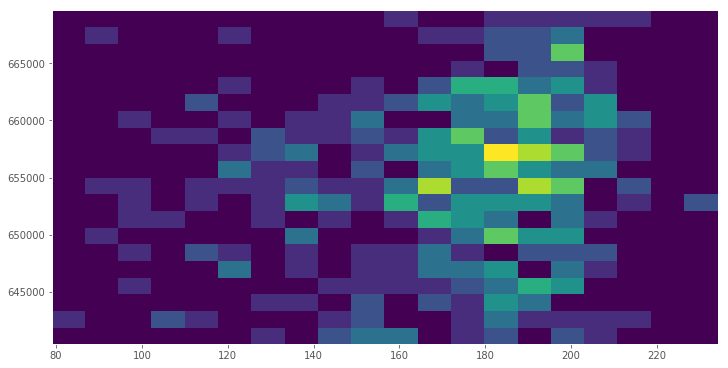

In [45]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])

ax.hist2d(edf['rmax'], edf['e'], bins=.2*nbins);

### 2.4.2 E vs Number of Slices

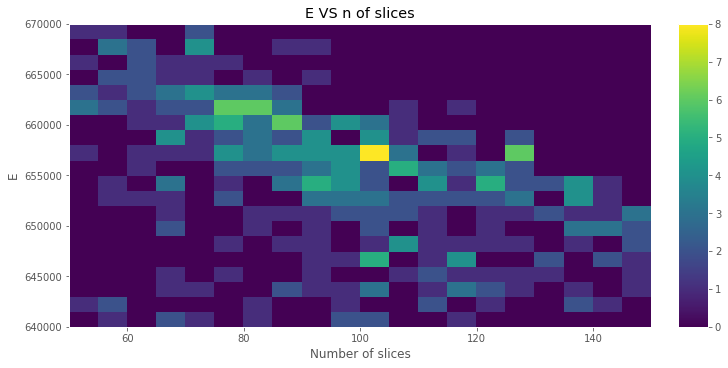

In [47]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(edf['nslices'], edf['e'] , bins=[.2*nbins, .2*nbins], 
                                   range=((50, 150),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_enslices.colorbar(hist_enslices[3], ax = ax_enslices)

*------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------*

# 3. CHARGE

## 3.1. Overview

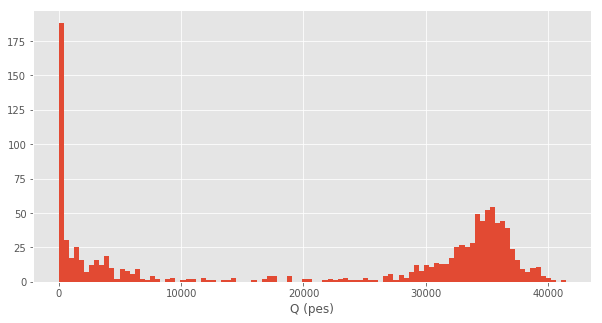

In [48]:
df['q'].hist(bins=nbins);
plt.xlabel('Q (pes)', fontsize=12);

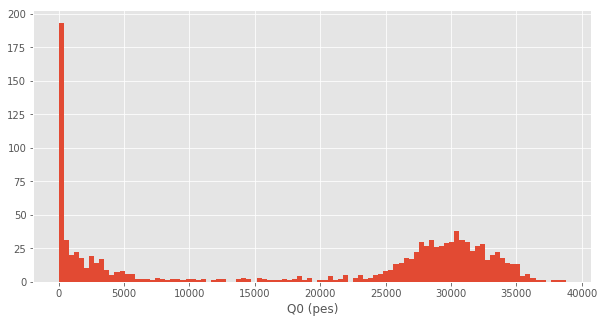

In [49]:
df['q0'].hist(bins=nbins);
plt.xlabel('Q0 (pes)', fontsize=12);

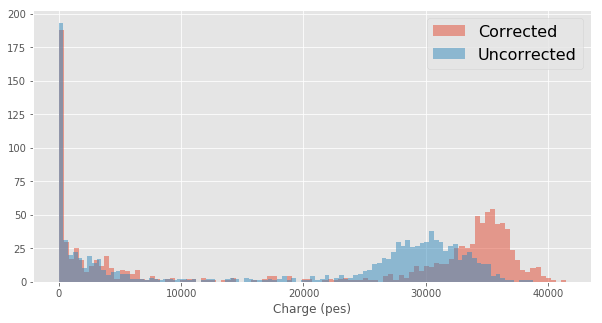

In [50]:
plt.hist(df['q'] , bins = nbins, alpha=.5, label='Corrected' );
plt.hist(df['q0'], bins = nbins, alpha=.5, label='Uncorrected' );
plt.legend(fontsize = 16);
plt.xlabel('Charge (pes)', fontsize=12);

## 3.2. Select region

In [51]:
Qmax = 40e3
Qmin = 30e3

In [52]:
qdf = df[(df.q<Qmax) & (df.q>Qmin)]

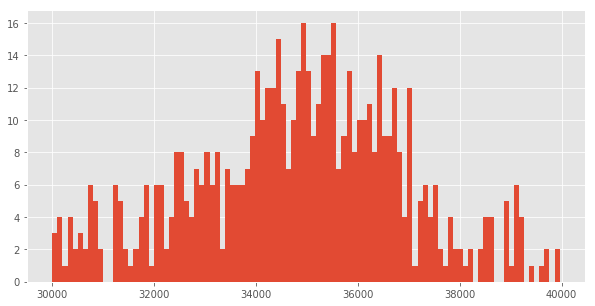

In [53]:
plt.hist(qdf['q'], bins=nbins);

## 3.3. Searching correlations

### 3.3.1. Corrected Charge correlations (Q vs All variables)

In [54]:
var = qdf.keys()
var = var[3:len(var)]
var

Index(['nslices', 'nhits', 'noqslices', 'noqhits', 'time', 's1e', 't0', 'rmax',
       'zmin', 'zmax', 'x0', 'y0', 'z0', 'q0', 'e0', 'x', 'y', 'z', 'q', 'e'],
      dtype='object')

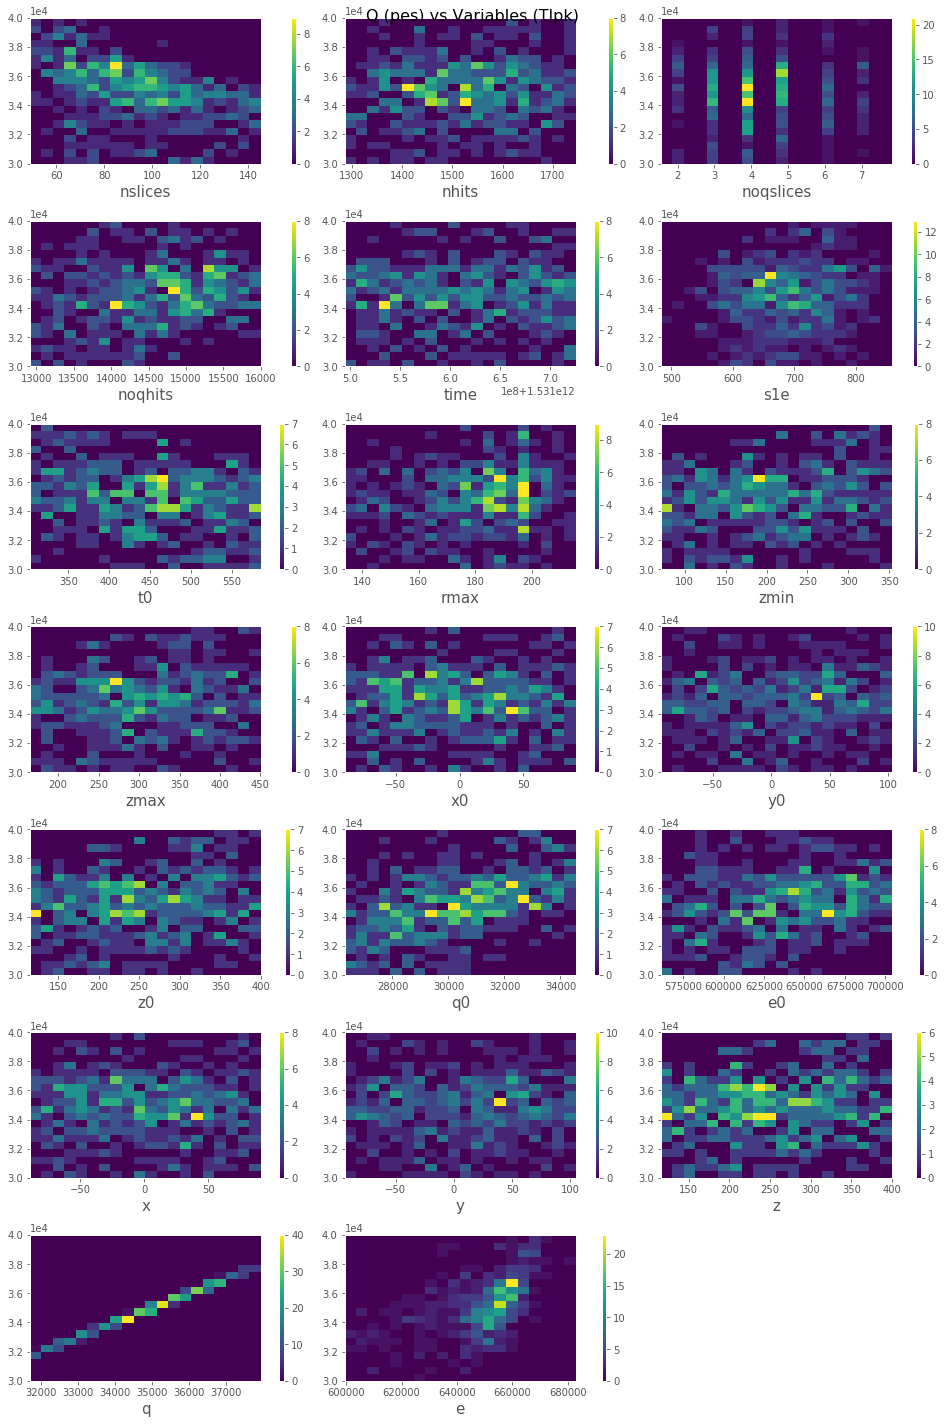

In [55]:
fig_q = plt.figure(figsize =[13, 20], constrained_layout=True);

gs_q = gridspec.GridSpec(round(len(var)/3+.5), 3, figure=fig_q);

i=0
for v in var:
    axes    = f'ax_q{v}   = fig_q.add_subplot(gs_q[{i}])'
    exec(axes)
    hist       = (f'hist_q{v} = ax_q{v}.hist2d(qdf["{v}"], qdf["q"] ,bins=.2*nbins,' + 
                  f'range=((np.mean(qdf["{v}"])-1.5*np.std(qdf["{v}"]), np.mean(qdf["{v}"])+1.5*np.std(qdf["{v}"])), (Qmin, Qmax)))')
    exec(hist)
    labels     = (f'ax_q{v}.set_xlabel("{v}", fontsize=15) \n'+
                  f'ax_q{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
    exec(labels)
    i+=1

for v in var:
    cbars      = f'cbar_q{v} = fig_q.colorbar(hist_q{v}[3], ax = ax_q{v})'
    exec(cbars)
fig_q.suptitle(f'Q (pes) vs Variables ({typo})', fontsize=16);

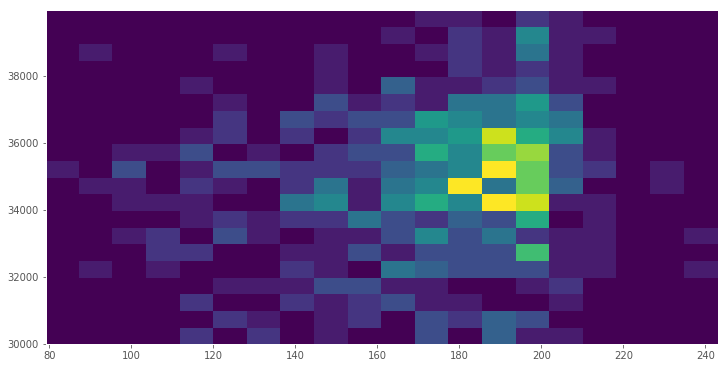

In [57]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])

ax.hist2d(qdf['rmax'], qdf['q'], bins=.2*nbins);

### 3.4.2 Q vs Number of Slices

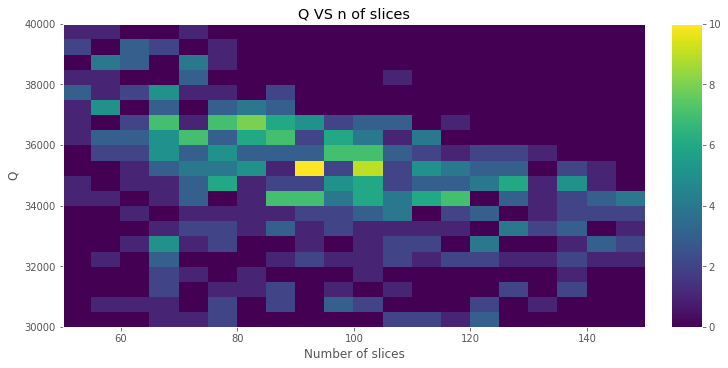

In [59]:
fig_qnslices = plt.figure(constrained_layout=True)

gs_qnslices = gridspec.GridSpec(1, 1, figure=fig_qnslices)

ax_qnslices = fig_qnslices.add_subplot(gs_qnslices[0, 0])
hist_qnslices = ax_qnslices.hist2d(qdf['nslices'], qdf['q'] , bins=[.2*nbins, .2*nbins],
                                   range=((50, 150),(Qmin, Qmax)));
ax_qnslices.set_xlabel('Number of slices');
ax_qnslices.set_ylabel('Q');
ax_qnslices.set_title('Q VS n of slices');
cbar_qnslices = fig_qnslices.colorbar(hist_qnslices[3], ax = ax_qnslices)

*------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------*

# 4. Energy/Charge

## 4.1. Photopeak selection and histogram

In [60]:
Emax = 670e3
Emin = 640e3

Qmax = 40e3
Qmin = 30e3

eqdf = df[(df.e<Emax)&(df.e>Emin)&(df.q<Qmax)&(df.q>Qmin)]

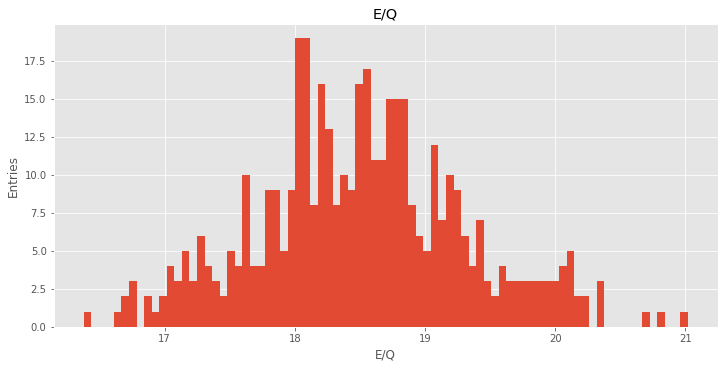

In [61]:
fig_eq = plt.figure(constrained_layout=True)

gs_eq = gridspec.GridSpec(1, 1, figure=fig_eq)

ax_hist = fig_eq.add_subplot(gs_eq[0])
hist_eq = ax_hist.hist(eqdf['e']/eqdf['q'], bins=int(.8*nbins));
ax_hist.set_xlabel('E/Q');
ax_hist.set_ylabel('Entries');
ax_hist.set_title('E/Q');

## 4.2. Correlations (E/Q vs all variables)

In [62]:
var = eqdf.keys()
var = var[3:len(var)]
var

Index(['nslices', 'nhits', 'noqslices', 'noqhits', 'time', 's1e', 't0', 'rmax',
       'zmin', 'zmax', 'x0', 'y0', 'z0', 'q0', 'e0', 'x', 'y', 'z', 'q', 'e'],
      dtype='object')

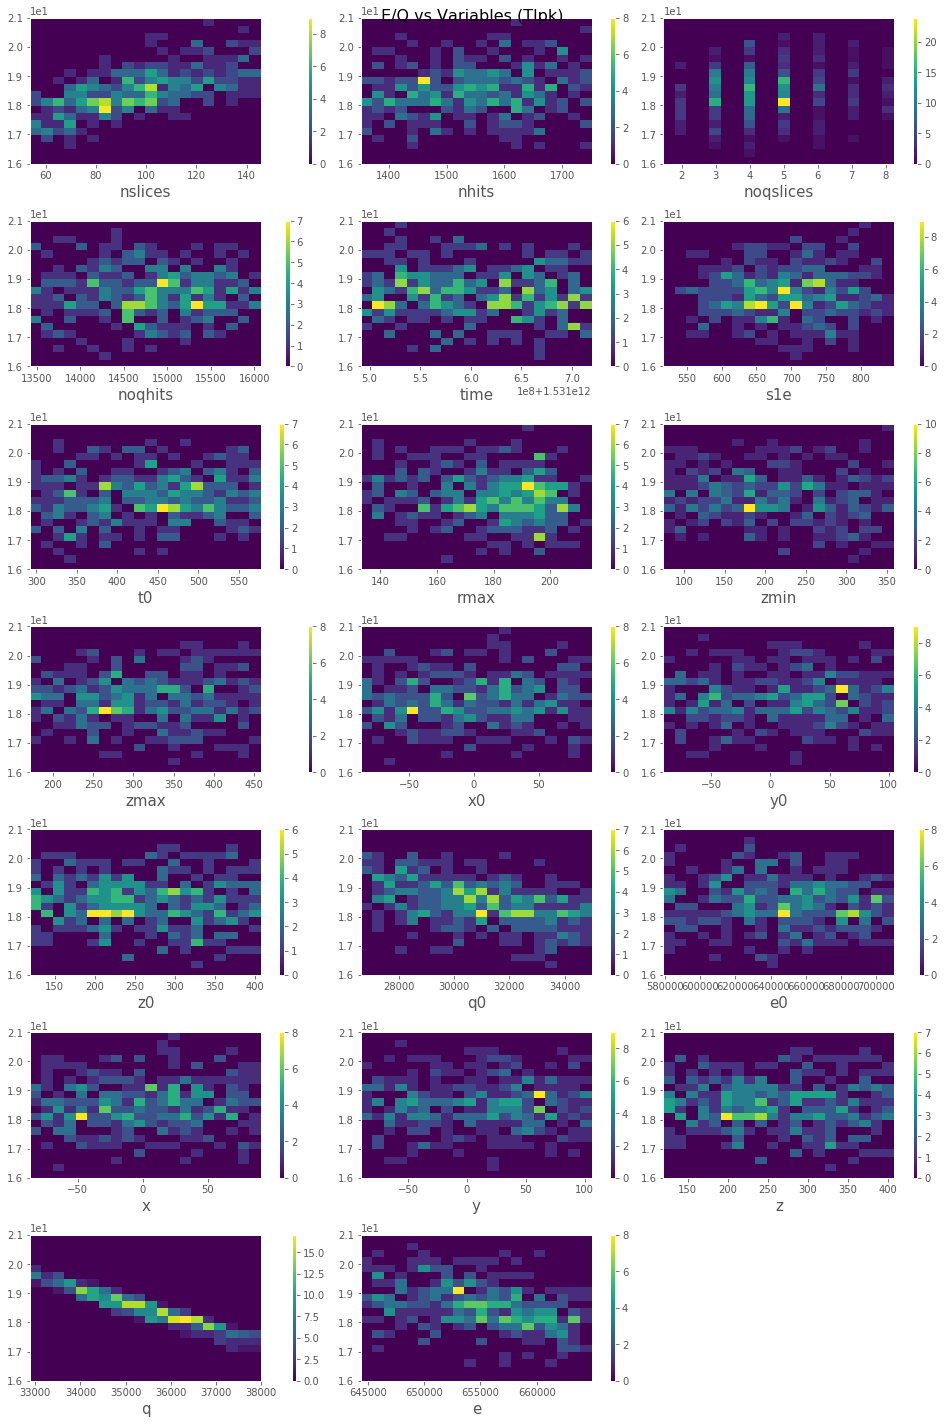

In [64]:
fig_eq = plt.figure(figsize =[13, 20], constrained_layout=True);

gs_eq = gridspec.GridSpec(round(len(var)/3+.5), 3, figure=fig_eq);

i=0
for v in var:
    axes    = f'ax_eq{v}   = fig_eq.add_subplot(gs_eq[{i}])'
    exec(axes)
    hist       = (f'hist_eq{v} = ax_eq{v}.hist2d(eqdf["{v}"], eqdf["e"]/eqdf["q"] ,bins=.2*nbins,' +
                  f'range=((np.mean(eqdf["{v}"])-1.5*np.std(eqdf["{v}"]), np.mean(eqdf["{v}"])+1.5*np.std(eqdf["{v}"])), (16, 21)))')
    exec(hist)
    labels     = (f'ax_eq{v}.set_xlabel("{v}", fontsize=15) \n'+
                  f'ax_eq{v}.ticklabel_format(style="sci", axis="y", scilimits=(0,0))')
    exec(labels)
    i+=1

for v in var:
    cbars      = f'cbar_eq{v} = fig_eq.colorbar(hist_eq{v}[3], ax = ax_eq{v})'
    exec(cbars)
fig_eq.suptitle(f'E/Q vs Variables ({typo})', fontsize=16);

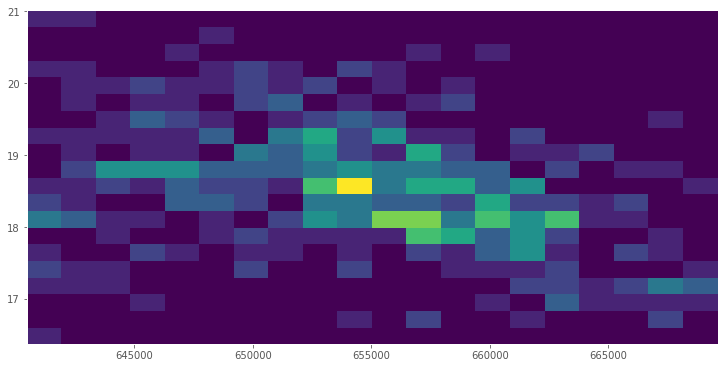

In [66]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0])

ax.hist2d(eqdf['e'], eqdf['e']/eqdf['q'], bins=.2*nbins);